In [1]:
# HIDE CODE
from dateutil.relativedelta import relativedelta
from joblib import dump, load
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.rcParams.update({'font.size': 12})


import warnings
import sys
import os
sys.path.append('/home/server/gli-data-science/')
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

import os
import ds_db
import helper_db
from helper import transform_to_rupiah, rupiah_format

import pickle
import pandas as pd
import numpy as np

from datetime import datetime, timedelta

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
pd.options.mode.chained_assignment = None  # default='warn'
from IPython.display import display, HTML, display_html, IFrame
import ipywidgets as ipyw

def side_by_side_display(dfs:list, captions:list):
    output = ""
    combined = dict(zip(captions, dfs))
    styles = [
        dict(selector="caption", props=[("caption-side", "center"), ("font-size", "100%"), ("color", )])]
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline; font-size:85%' ").set_precision(2).set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0\xa0"

    display(HTML(output))

    
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, PoissonRegressor, Ridge, Lasso, RANSACRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

import textwrap
def split_label(list_label):
    list_label = list(list_label)
    list_label = ["<br>".join(textwrap.wrap(t, width=12)) for t in list_label ]
    return list_label

### ide kasar
> 
* daily job to loop all member alfagift 10 juta
* compute feature trx voucher used, # of trx, # of sales
* compute feature event app site open / view product / atc
* updating each feature and re predict churn feature
* lets play in month - 3 for each define trx and event feature

In [2]:
pv1 = pd.read_csv('./pv_01Sep21.csv')
pv2 = pd.read_csv('./pv_01Oct21.csv')
pv3 = pd.read_csv('./pv_01Nov21.csv')

df_pv = pv1.merge(pv2, on='TRO_MEMBERS', how='outer').merge(pv3, on='TRO_MEMBERS', how='outer').rename(
                                columns={'COUNT_VIEW_PRODUCT_x':'PV_2021-09',
                                        'COUNT_VIEW_PRODUCT_y':'PV_2021-10',
                                        'COUNT_VIEW_PRODUCT':'PV_2021-11'})


In [3]:
from datetime import datetime
now = datetime.now()
now_ = datetime(now.year, now.month, now.day)
## 9990010000070044
# sample with minus

q = '''

select 
    ttdr.tbtdr_created_date, 
    ttdr.tbtdr_ponta_user AS TRO_MEMBERS, 
    ttdr.tbtdr_tbto_id, 
    ttdr.tbtdr_rating AS rating
from 
    tb_transaction_delivery_rating ttdr 
where 
    ttdr.tbtdr_created_date between '2021-09-01' and '2021-12-01'
    and ttdr.tbtdr_rating > 0
'''.format(now_)

con, cur = ds_db.connect_prd_order_4()
df_re = pd.read_sql(q, con)


con.close()

df_re['created_date'] = df_re['tbtdr_created_date'].dt.strftime('%Y-%m')
df_re = df_re[df_re['tro_members'] != '']

## groupby and get feature by rating below good and rating avg
df_re_g = df_re.groupby(['tro_members', 'created_date']).agg(
                                rating_below = ('rating', lambda x: len(x[x<3])),
                                rating_avg = ('rating','mean')
                            )
df_re_g_u = df_re_g.unstack(level=1).fillna(0).reset_index()
df_re_g_u.columns = [' '.join(col).strip().upper() for col in df_re_g_u.columns.values]

df_re_g_u.head(20)

You are connected


,TRO_MEMBERS,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11
0,9990010000069277,0.0,0.0,0.0,5.0,0.0,0.0
1,9990010000070044,0.0,0.0,0.0,5.0,0.0,0.0
2,9990010000089999,0.0,0.0,0.0,0.0,5.0,0.0
3,9990010000191790,0.0,0.0,0.0,0.0,5.0,5.0
4,9990010000196641,0.0,0.0,0.0,5.0,5.0,0.0
5,9990010000198083,0.0,0.0,0.0,0.0,5.0,0.0
6,9990010000208214,0.0,0.0,0.0,5.0,5.0,0.0
7,9990010000209455,0.0,0.0,0.0,5.0,0.0,0.0
8,9990010000209683,0.0,0.0,1.0,0.0,5.0,1.0
9,9990010000212946,0.0,0.0,0.0,0.0,5.0,0.0


In [4]:
df_re['tbtdr_created_date'].min(), df_re['tbtdr_created_date'].max()

(Timestamp('2021-09-01 00:16:15.200000'),
 Timestamp('2021-11-30 23:51:16.002000'))

In [5]:
# HIDE CODE

## USING ORDER
import glob

df_tto = []
for end_date in pd.date_range('2021-07-01', '2022-01-01', freq='M'):
    start_date = end_date.replace(day=1)
    end_date_save = start_date + relativedelta(months=1)
    
    start_date_str = start_date.strftime('%d%b%y')
    end_date_str = end_date_save.strftime('%d%b%y')
    
    print(start_date_str, end_date_str)
    
    pf = '/home/server/gli-data-science/data/trans_oshop/{}_{}.csv'.format(start_date_str, end_date_str)
    df_tto.append(pd.read_csv(pf, sep='\t', dtype='object'))
    
df_tto = pd.concat(df_tto)

df_tto = df_tto[df_tto['TRO_MEMBERS'] != 'N']
df_tto['TRO_DATE'] = pd.to_datetime(df_tto['TRO_DATE'])
df_tto['TRO_NET'] = df_tto['TRO_NET'].astype('float', errors='ignore').astype('int', errors='ignore')


df_tto['TRO_QTY'] = df_tto['TRO_QTY'].astype(int)

01Jul21 01Aug21
01Aug21 01Sep21
01Sep21 01Oct21
01Oct21 01Nov21
01Nov21 01Dec21
01Dec21 01Jan22


In [6]:
df_tto['TRO_VOUCHER_USAGE'] = df_tto['TRO_VOUCHER_USAGE'].astype('float', errors='ignore').astype('int', errors='ignore')
df_tto['TRO_DATE_MONTH'] = df_tto['TRO_DATE'].dt.strftime('%Y-%m')


In [7]:
df_tto_sel = df_tto[(df_tto['TRO_DATE'] >= '2021-09-01') \
            & (df_tto['TRO_DATE'] <= '2021-12-31')]

In [8]:
df_sla = pd.read_csv('./sla_01Dec21.csv')
df_sla['ATT_SEND_DATE_TOSTORE'] = pd.to_datetime(df_sla['ATT_SEND_DATE_TOSTORE'])
df_sla['SLA'] = np.where(df_sla['SLA_NORM']< 0, 20, df_sla['SLA_NORM'])

In [9]:
df_tto_sel = pd.merge(df_tto_sel, df_sla, left_on='TRO_NO_ORDER', right_on='ATT_ORDER_ID', how='left')
df_tto_sel = df_tto_sel.drop(['ATT_ORDER_ID','ATT_ORDER_DATE','ATT_DELIVERY_DATE','ATT_SEND_DATE_TOSTORE','SLA_NORM'],1)

In [10]:
df_tto_sel['SLA'] = df_tto_sel['SLA'].fillna(20)
df_tto_sel['SLA_LATE'] = np.where(df_tto_sel['SLA'] > 60, 1,0)

In [11]:
df_tto_sel[df_tto_sel['SLA'].notnull()].head()

,TRO_DATE,TRO_CART_ID,TRO_KD_STORE,TRO_BRANCH_CODE,BRANCH_CODE,TRO_MEMBERS,TRO_NO_ORDER,TRO_PLU,TRO_QTY,TRO_VOUCHER_USAGE,TRO_PAYMENT_METHOD,TRO_NET,TRO_SHIP_METHOD,TRO_STATUS_SAPA,TRO_STATUS_RETUR,TRO_DATE_MONTH,SLA,SLA_LATE
0,2021-09-05,10873363,CG09,CZ01,CZ01,9990013363654765,O-210905-AGMCRTZ,124628,1,0.0,sat-cod,55000,1,Y,N,2021-09,6.7,0
1,2021-09-05,10873363,CG09,CZ01,CZ01,9990013363654765,O-210905-AGMCRTZ,174590,1,0.0,sat-cod,4636,1,Y,N,2021-09,6.7,0
2,2021-09-05,10873363,CG09,CZ01,CZ01,9990013363654765,O-210905-AGMCRTZ,176010,1,0.0,sat-cod,4636,1,Y,N,2021-09,6.7,0
3,2021-09-05,10873363,CG09,CZ01,CZ01,9990013363654765,O-210905-AGMCRTZ,219707,1,0.0,sat-cod,10454,1,Y,N,2021-09,6.7,0
4,2021-09-05,10854981,CG10,CZ01,CZ01,9990013137230742,O-210905-AGBTPCB,103002,1,0.0,shopeepay,181,0,N,N,2021-09,1592.4,1


In [12]:
df_tto_sel_g = df_tto_sel.groupby(['TRO_MEMBERS','TRO_DATE_MONTH','TRO_NO_ORDER'])\
                        .agg({'TRO_NET':'sum',
                              'TRO_NO_ORDER':'nunique',
                              'SLA':'first',
                              'SLA_LATE':'first'
                             })
df_tto_sel_g = df_tto_sel_g.groupby(['TRO_MEMBERS','TRO_DATE_MONTH'])\
                        .agg({'TRO_NET':'sum',
                              'TRO_NO_ORDER':'sum',
                              'SLA':'sum',
                              'SLA_LATE':'sum'
                             })

In [13]:
df_tto_sel_g_u = df_tto_sel_g.unstack(level=1).fillna(0).reset_index()
df_tto_sel_g_u.columns = [' '.join(col).strip().upper() for col in df_tto_sel_g_u.columns.values]

In [14]:
df_tto_re = pd.merge(df_tto_sel_g_u, df_re_g_u, on='TRO_MEMBERS', how='left').fillna(0)

In [41]:
df_tto_re.head()

,TRO_MEMBERS,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,SLA 2021-09,SLA 2021-10,SLA 2021-11,SLA 2021-12,SLA_LATE 2021-09,SLA_LATE 2021-10,SLA_LATE 2021-11,SLA_LATE 2021-12,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11
0,006506519712,0.0,0.0,50362.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9990010000001200,1791590.0,2412654.0,3117811.0,3217556.0,20.0,35.0,49.0,40.0,217.1,480.8,630.1,710.1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9990010000004582,0.0,191267.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,9951.7,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9990010000008534,202358.0,644400.0,165315.0,776032.0,4.0,10.0,3.0,8.0,73.3,214.9,93.3,159.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9990010000031123,0.0,0.0,412904.0,48908.0,0.0,0.0,4.0,1.0,0.0,0.0,34.6,359.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
df_pv['TRO_MEMBERS'] = df_pv['TRO_MEMBERS'].astype(str)
df_tto_re_pv = pd.merge(df_tto_re, df_pv, on='TRO_MEMBERS', how='left').fillna(0)

In [42]:
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)

In [43]:
# condition = ( 
#           (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
#           (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
#           (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
#           (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
# )
# df_tto_re_pv['label'] = np.where(condition, 1, 0)

In [44]:
df_tto_re_pv['NET_11-10'] = df_tto_re_pv['TRO_NET 2021-11'] - df_tto_re_pv['TRO_NET 2021-10']
df_tto_re_pv['NET_10-09'] = df_tto_re_pv['TRO_NET 2021-10'] - df_tto_re_pv['TRO_NET 2021-09']
df_tto_re_pv['NET_11-09'] = df_tto_re_pv['TRO_NET 2021-11'] - df_tto_re_pv['TRO_NET 2021-09']
df_tto_re_pv['STRUK_11-10'] = df_tto_re_pv['TRO_NO_ORDER 2021-11'] - df_tto_re_pv['TRO_NO_ORDER 2021-10']
df_tto_re_pv['STRUK_10-09'] = df_tto_re_pv['TRO_NO_ORDER 2021-10'] - df_tto_re_pv['TRO_NO_ORDER 2021-09']
df_tto_re_pv['STRUK_11-09'] = df_tto_re_pv['TRO_NO_ORDER 2021-11'] - df_tto_re_pv['TRO_NO_ORDER 2021-09']

In [45]:
# print(df_ins[df_ins['label'] == 1]['NET_11-10'].median())
# print(df_ins[df_ins['label'] == 1]['NET_10-09'].median())
# print(df_ins[df_ins['label'] == 1]['NET_11-09'].median())
# print(df_ins[df_ins['label'] == 1]['STRUK_11-10'].mean())
# print(df_ins[df_ins['label'] == 1]['STRUK_10-09'].mean())
# print(df_ins[df_ins['label'] == 1]['STRUK_11-09'].mean())

In [46]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [47]:
# clf_ridge = RidgeClassifier() 
# clf_ridge.fit(X_train, y_train) 
# pred = clf_ridge.predict(X_test)

# print(classification_report(y_test, pred))
# fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# plot_confusion_matrix(clf_ridge, X_test, y_test, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

In [48]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
# clf_ridge = LogisticRegression()  
# clf_ridge.fit(X_train, y_train) 
# pred = clf_ridge.predict(X_test)

# print(classification_report(y_test, pred))
# fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# plot_confusion_matrix(clf_ridge, X_test, y_test, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

In [49]:
# clf_ridge = DecisionTreeClassifier(random_state=0, max_depth=15) 
# clf_ridge.fit(X_train, y_train) 
# pred = clf_ridge.predict(X_test)

# print(classification_report(y_test, pred))
# fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# ConfusionMatrixDisplay.from_predictions(y_test, pred, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)
# # from sklearn.tree import export_text
# # r = export_text(clf_ridge, feature_names=list(X_train), decimals=0, spacing=6)
# # print("prediction rule \n{}".format(r))

### RANDOM FOREST MODEL

### not oversampling version with threshold

              precision    recall  f1-score   support

           0       0.90      1.00      0.95    182706
           1       0.80      0.04      0.08     20810

    accuracy                           0.90    203516
   macro avg       0.85      0.52      0.51    203516
weighted avg       0.89      0.90      0.86    203516



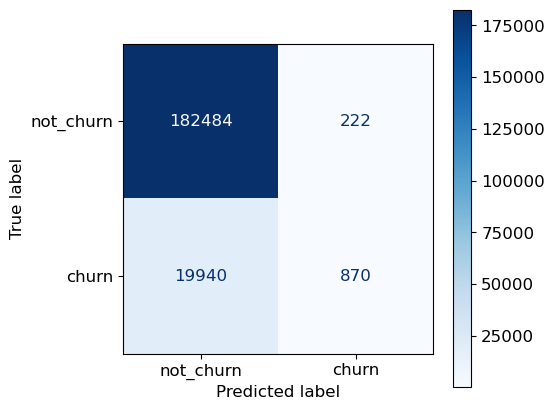

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

clf_ridge = RandomForestClassifier(random_state=42) 
clf_ridge.fit(X_train, y_train) 
# pred_proba = clf_ridge.predict_proba(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] > 0.8).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

### not oversampling version without threshold

              precision    recall  f1-score   support

           0       0.93      0.97      0.95    182706
           1       0.59      0.40      0.48     20810

    accuracy                           0.91    203516
   macro avg       0.76      0.68      0.71    203516
weighted avg       0.90      0.91      0.90    203516



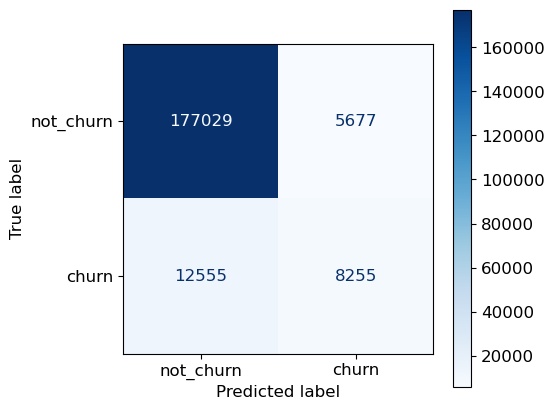

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

clf_ridge = RandomForestClassifier(random_state=42) 
clf_ridge.fit(X_train, y_train) 

pred = clf_ridge.predict(X_test)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

In [52]:
df_res = pd.concat([
    pd.concat([df_tto_re_pv.drop(['label'],1).loc[X_test.index, :].reset_index(drop=True), pd.DataFrame({'pred':pred})],1), 
    y_test.reset_index(drop=True)],1)

In [53]:
df_res[(df_res['label'] == 0) & (df_res['pred'] == 1)].head(10)

,TRO_MEMBERS,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,SLA 2021-09,SLA 2021-10,SLA 2021-11,SLA 2021-12,SLA_LATE 2021-09,SLA_LATE 2021-10,SLA_LATE 2021-11,SLA_LATE 2021-12,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,PV_2021-09,PV_2021-10,PV_2021-11,NET_11-10,NET_10-09,NET_11-09,STRUK_11-10,STRUK_10-09,STRUK_11-09,pred,label
13,9990011814996421,53271.0,106181.0,0.0,69817.0,1.0,2.0,0.0,1.0,20.0,20.9,0.0,6.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,7.0,1.0,-106181.0,52910.0,-53271.0,-2.0,1.0,-1.0,1,0
34,9990013067256179,0.0,218362.0,14726.0,281389.0,0.0,1.0,4.0,3.0,0.0,1164.9,7524.1,3348.2,0.0,1.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,197.0,-203636.0,218362.0,14726.0,3.0,1.0,4.0,1,0
108,9990013024407074,64000.0,82180.0,67045.0,111998.0,1.0,1.0,1.0,1.0,20.0,37.0,2.7,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-15135.0,18180.0,3045.0,0.0,0.0,0.0,1,0
118,9990013422918422,97180.0,0.0,48860.0,96088.0,1.0,0.0,1.0,1.0,25.4,0.0,37.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,48860.0,-97180.0,-48320.0,1.0,-1.0,0.0,1,0
148,9990011896742023,300541.0,2169334.0,0.0,469444.0,2.0,34.0,0.0,6.0,2403.4,1426.2,0.0,304.2,1.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,21.0,3.0,-2169334.0,1868793.0,-300541.0,-34.0,32.0,-2.0,1,0
154,9990012726307730,309453.0,1756407.0,0.0,841090.0,1.0,2.0,0.0,1.0,9.2,2874.8,0.0,356.8,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,2.0,-1756407.0,1446954.0,-309453.0,-2.0,1.0,-1.0,1,0
161,9990013226504196,48800.0,271562.0,0.0,121786.0,2.0,1.0,0.0,1.0,2820.6,35.2,0.0,4.6,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,1.0,-271562.0,222762.0,-48800.0,-1.0,-1.0,-2.0,1,0
166,9990011411090610,127908.0,0.0,170179.0,451129.0,1.0,0.0,1.0,2.0,12.4,0.0,6.8,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,2.0,0.0,4.0,170179.0,-127908.0,42271.0,1.0,-1.0,0.0,1,0
174,9990013259940321,225220.0,139040.0,0.0,139540.0,5.0,3.0,0.0,2.0,255.3,120.9,0.0,153.8,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,9.0,0.0,-139040.0,-86180.0,-225220.0,-3.0,-2.0,-5.0,1,0
206,9990013370228132,117087.0,40090.0,0.0,117451.0,1.0,1.0,0.0,2.0,876.7,26.5,0.0,1177.3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,-40090.0,-76997.0,-117087.0,-1.0,0.0,-1.0,1,0


In [54]:
df_res[(df_res['label'] == 1) & (df_res['pred'] == 0)].head(10)

,TRO_MEMBERS,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,SLA 2021-09,SLA 2021-10,SLA 2021-11,SLA 2021-12,SLA_LATE 2021-09,SLA_LATE 2021-10,SLA_LATE 2021-11,SLA_LATE 2021-12,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,PV_2021-09,PV_2021-10,PV_2021-11,NET_11-10,NET_10-09,NET_11-09,STRUK_11-10,STRUK_10-09,STRUK_11-09,pred,label
2,9990010877830779,164497.0,219997.0,368264.0,0.0,2.0,3.0,3.0,0.0,32.1,41.4,409.8,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,35.0,20.0,148267.0,55500.0,203767.0,0.0,1.0,1.0,0,1
35,9990013149285098,138993.0,156903.0,85087.0,0.0,3.0,3.0,2.0,0.0,1867.0,527.3,454.1,0.0,3.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,20.0,8.0,-71816.0,17910.0,-53906.0,-1.0,0.0,-1.0,0,1
37,9990013301518214,304812.0,548813.0,0.0,0.0,2.0,5.0,0.0,0.0,3628.3,137.6,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,17.0,3.0,-548813.0,244001.0,-304812.0,-5.0,3.0,-2.0,0,1
46,9990013222374930,77726.0,413539.0,0.0,0.0,1.0,3.0,0.0,0.0,2426.9,3581.9,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,28.0,10.0,-413539.0,335813.0,-77726.0,-3.0,2.0,-1.0,0,1
103,9990011535920933,0.0,78545.0,62724.0,0.0,0.0,1.0,1.0,0.0,0.0,20.0,10.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,7.0,13.0,-15821.0,78545.0,62724.0,0.0,1.0,1.0,0,1
119,9990013368969369,295452.0,355451.0,1035988.0,0.0,2.0,2.0,6.0,0.0,33.1,19.1,189.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,0.0,680537.0,59999.0,740536.0,4.0,0.0,4.0,0,1
126,9990010006386597,0.0,296359.0,284634.0,0.0,0.0,1.0,1.0,0.0,0.0,1.6,1715.2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.0,4.0,-11725.0,296359.0,284634.0,0.0,1.0,1.0,0,1
127,9990013445682913,0.0,141725.0,107179.0,0.0,0.0,1.0,2.0,0.0,0.0,20.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,19.0,17.0,-34546.0,141725.0,107179.0,1.0,1.0,2.0,0,1
139,9990013373093743,526619.0,0.0,208814.0,0.0,3.0,0.0,2.0,0.0,110.8,0.0,55.8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,33.0,10.0,24.0,208814.0,-526619.0,-317805.0,2.0,-3.0,-1.0,0,1
143,9990013417764449,166343.0,56181.0,81933.0,0.0,3.0,1.0,2.0,0.0,51.2,10.5,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25752.0,-110162.0,-84410.0,1.0,-2.0,-1.0,0,1


### oversampling version

              precision    recall  f1-score   support

           0       0.91      0.99      0.95    182706
           1       0.63      0.19      0.29     20810

    accuracy                           0.91    203516
   macro avg       0.77      0.59      0.62    203516
weighted avg       0.89      0.91      0.88    203516



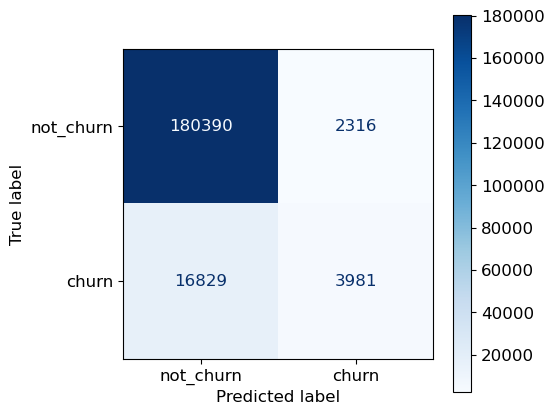

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)


from imblearn.over_sampling import SMOTE
oversampler = SMOTE(random_state=0)
X_train ,y_train = oversampler.fit_resample(X_train, y_train)


clf_ridge = RandomForestClassifier(n_jobs=32) 
clf_ridge.fit(X_train, y_train) 
# pred = clf_ridge.predict(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] > 0.8).astype(int)


print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

In [63]:
df_res = pd.concat([
    pd.concat([df_tto_re_pv.drop(['label'],1).loc[X_test.index, :].reset_index(drop=True), pd.DataFrame({'pred':pred})],1), 
    y_test.reset_index(drop=True)],1)

In [64]:
df_res[(df_res['label'] == 0) & (df_res['pred'] == 1)].head(10)

,TRO_MEMBERS,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,SLA 2021-09,SLA 2021-10,SLA 2021-11,SLA 2021-12,SLA_LATE 2021-09,SLA_LATE 2021-10,SLA_LATE 2021-11,SLA_LATE 2021-12,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,PV_2021-09,PV_2021-10,PV_2021-11,NET_11-10,NET_10-09,NET_11-09,STRUK_11-10,STRUK_10-09,STRUK_11-09,pred,label
13,9990011814996421,53271.0,106181.0,0.0,69817.0,1.0,2.0,0.0,1.0,20.0,20.9,0.0,6.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,7.0,1.0,-106181.0,52910.0,-53271.0,-2.0,1.0,-1.0,1,0
206,9990013370228132,117087.0,40090.0,0.0,117451.0,1.0,1.0,0.0,2.0,876.7,26.5,0.0,1177.3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,-40090.0,-76997.0,-117087.0,-1.0,0.0,-1.0,1,0
220,9990011277736000,0.0,60726.0,113361.0,54725.0,0.0,1.0,2.0,1.0,0.0,14.1,42.3,14.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,2.0,52635.0,60726.0,113361.0,1.0,1.0,2.0,1,0
277,9990012349884060,135082.0,80811.0,114539.0,96815.0,1.0,1.0,1.0,1.0,14.6,15.4,20.2,29.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,33728.0,-54271.0,-20543.0,0.0,0.0,0.0,1,0
318,9990013426162114,152448.0,0.0,40544.0,66089.0,2.0,0.0,1.0,1.0,18.0,0.0,8.4,8.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40544.0,-152448.0,-111904.0,1.0,-2.0,-1.0,1,0
357,9990013074043541,32363.0,96270.0,0.0,106995.0,1.0,2.0,0.0,1.0,17.8,48.1,0.0,62.8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,-96270.0,63907.0,-32363.0,-2.0,1.0,-1.0,1,0
398,9990013257542739,0.0,33907.0,19544.0,25180.0,0.0,1.0,1.0,1.0,0.0,1819.7,1502.1,20.2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,4.0,4.0,-14363.0,33907.0,19544.0,0.0,1.0,1.0,1,0
419,9990013367456467,79361.0,0.0,71454.0,200180.0,1.0,0.0,1.0,1.0,6.1,0.0,37.3,55.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,4.0,71454.0,-79361.0,-7907.0,1.0,-1.0,0.0,1,0
510,9990013361110562,132632.0,177267.0,0.0,294085.0,1.0,1.0,0.0,1.0,4.2,7.2,0.0,20.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,3.0,0.0,-177267.0,44635.0,-132632.0,-1.0,0.0,-1.0,1,0
521,9990011895350283,53043.0,82725.0,0.0,74543.0,1.0,1.0,0.0,1.0,7.8,574.3,0.0,3.1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,-82725.0,29682.0,-53043.0,-1.0,0.0,-1.0,1,0


In [58]:
df_res[(df_res['label'] == 1) & (df_res['pred'] == 0)].head(10)

,TRO_MEMBERS,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,SLA 2021-09,SLA 2021-10,SLA 2021-11,SLA 2021-12,SLA_LATE 2021-09,SLA_LATE 2021-10,SLA_LATE 2021-11,SLA_LATE 2021-12,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,PV_2021-09,PV_2021-10,PV_2021-11,NET_11-10,NET_10-09,NET_11-09,STRUK_11-10,STRUK_10-09,STRUK_11-09,pred,label
2,9990010877830779,164497.0,219997.0,368264.0,0.0,2.0,3.0,3.0,0.0,32.1,41.4,409.8,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,35.0,20.0,148267.0,55500.0,203767.0,0.0,1.0,1.0,0,1
17,9990011968780046,280350.0,104038.0,0.0,0.0,4.0,2.0,0.0,0.0,103.7,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,85.0,49.0,0.0,-104038.0,-176312.0,-280350.0,-2.0,-2.0,-4.0,0,1
35,9990013149285098,138993.0,156903.0,85087.0,0.0,3.0,3.0,2.0,0.0,1867.0,527.3,454.1,0.0,3.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,20.0,8.0,-71816.0,17910.0,-53906.0,-1.0,0.0,-1.0,0,1
46,9990013222374930,77726.0,413539.0,0.0,0.0,1.0,3.0,0.0,0.0,2426.9,3581.9,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,28.0,10.0,-413539.0,335813.0,-77726.0,-3.0,2.0,-1.0,0,1
119,9990013368969369,295452.0,355451.0,1035988.0,0.0,2.0,2.0,6.0,0.0,33.1,19.1,189.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,0.0,680537.0,59999.0,740536.0,4.0,0.0,4.0,0,1
126,9990010006386597,0.0,296359.0,284634.0,0.0,0.0,1.0,1.0,0.0,0.0,1.6,1715.2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.0,4.0,-11725.0,296359.0,284634.0,0.0,1.0,1.0,0,1
127,9990013445682913,0.0,141725.0,107179.0,0.0,0.0,1.0,2.0,0.0,0.0,20.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,19.0,17.0,-34546.0,141725.0,107179.0,1.0,1.0,2.0,0,1
139,9990013373093743,526619.0,0.0,208814.0,0.0,3.0,0.0,2.0,0.0,110.8,0.0,55.8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,33.0,10.0,24.0,208814.0,-526619.0,-317805.0,2.0,-3.0,-1.0,0,1
143,9990013417764449,166343.0,56181.0,81933.0,0.0,3.0,1.0,2.0,0.0,51.2,10.5,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25752.0,-110162.0,-84410.0,1.0,-2.0,-1.0,0,1
169,9990013357745580,96633.0,184812.0,197081.0,0.0,2.0,2.0,2.0,0.0,36.3,88.9,113.9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,6.0,12269.0,88179.0,100448.0,0.0,0.0,0.0,0,1


## USING XGBOOST

### oversampling version

[14:20:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.98      0.89      0.93    182706
           1       0.45      0.81      0.58     20810

    accuracy                           0.88    203516
   macro avg       0.71      0.85      0.75    203516
weighted avg       0.92      0.88      0.89    203516



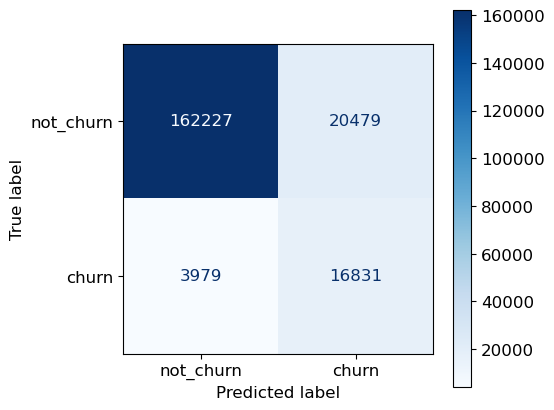

In [59]:
import xgboost as xgb 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)


scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)


from imblearn.over_sampling import SMOTE
oversampler = SMOTE(random_state=0)
X_train ,y_train = oversampler.fit_resample(X_train, y_train)

clf_ridge = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1)
clf_ridge.fit(X_train, y_train) 
pred = clf_ridge.predict(X_test)




print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')


### not oversampling version

[14:20:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.98      0.89      0.93    182706
           1       0.45      0.81      0.58     20810

    accuracy                           0.88    203516
   macro avg       0.71      0.85      0.75    203516
weighted avg       0.92      0.88      0.89    203516



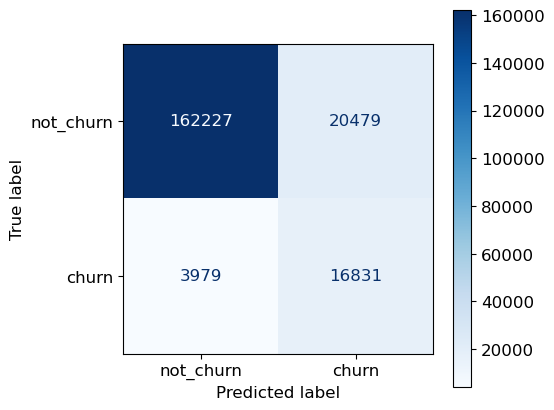

In [60]:
import xgboost as xgb 




scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

clf_ridge = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1)
clf_ridge.fit(X_train, y_train) 
pred = clf_ridge.predict(X_test)

print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', 
                                        display_labels= ['not_churn', 'churn'], ax = ax, values_format = 'd')


In [36]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
# def randomForest_fit(x_train, y_train, scoring = 'f1_macro'):
#     randomForest = RandomForestClassifier(random_state=123)

#     hyperparam = {'min_samples_leaf': [3, 5, 7, 9, 13, 17, 21, 27, 33, 41, 50, 60, 80, 100],
#                   'max_features': ['sqrt', 'log2', 0.25, 0.5, 0.75], 
#                   'n_estimators': [100, 200, 300, 500, 750, 1000]}
    
# #     random_randomForest = RandomizedSearchCV(randomForest, param_distributions = hyperparam, cv = 5, 
# #                                            n_iter = 6, scoring = scoring, n_jobs=-1, random_state = 123) 
# #     to long running time
#     random_randomForest = GridSearchCV(randomForest, param_grid = hyperparam, cv = 5, 
#                                         scoring = scoring, n_jobs=32)
#     random_randomForest.fit(x_train, y_train)
    
#     print ("Best F1", random_randomForest.best_score_)
#     print ("Best Param", random_randomForest.best_params_)
#     return random_randomForest

# best_randForest = randomForest_fit(X, y)

In [37]:
# randForest = RandomForestClassifier(random_state=123, n_jobs = -1,
#                                    min_samples_leaf = best_randForest.best_params_.get('min_samples_leaf'),
#                                    max_features = best_randForest.best_params_.get('max_features'),
#                                    n_estimators = best_randForest.best_params_.get('n_estimators'))
# name = randForest.__class__.__name__
# randForest.fit(X_train, y_train) 
# pred = randForest.predict(X_test)

# print(classification_report(y_test, pred))
# fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# plot_confusion_matrix(clf_ridge, X_test, y_test, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

In [38]:
# coba cek master member
# join dengan member id yang 8 angka
# cari create date dengan member yang terbaru

In [39]:
# import cx_Oracle
# from sqlalchemy import event,create_engine,types

# driver = 'cx_oracle'
# server = '10.234.152.61' 
# database = 'alfabi' 
# username = 'report' 
# password = 'justd0it'
# engine_stmt = "oracle://%s:%s@%s/%s" % (username, password, server, database )

# engine = create_engine(engine_stmt)

# df = df_tto_re[['TRO_MEMBERS']]
# dtyp = {c:types.VARCHAR(df[c].str.len().max()) for c in df.columns[df.dtypes == 'object'].tolist()}
# df.to_sql('temp_churn', engine, index=False, if_exists="replace", dtype=dtyp)

# engine.dispose()

In [40]:
# li_df_pv = []

# for dr in pd.date_range('2021-11-01', '2021-11-30'):
#     df_f = dr.strftime('%d-%b-%y')
#     q = '''
#     SELECT 
#         tc.TRO_MEMBERS, 
#         count(ame.AME_CART_PRODUCT_ID) AS COUNT_VIEW_PRODUCT
#     FROM 
#         TEMP_CHURN tc
#         LEFT JOIN PLMS_MEMBER_PROFILE pmp 
#         ON pmp.PMP_MEMBER_ID = tc.TRO_MEMBERS 
#         LEFT JOIN ALFAGIFT_MOE_EVENTS ame 
#         ON ame.AME_PONTA_ID = pmp.PMP_MEMBER_UNIQUE_ID 
#         LEFT JOIN ALFAGIFT_MASTER_PRODUCT amp 
#         ON amp.PRODUCT_ID = ame.AME_CART_PRODUCT_ID 
#     WHERE 
#         TRUNC(ame.AME_EVENT_TIME) BETWEEN '{}' AND '{}'
#         AND ame.AME_EVENT_NAME = 'view_product'
#     GROUP BY tc.TRO_MEMBERS

#     '''.format(df_f, df_f)
#     con = ds_db.connect_alfabi()
#     df_pv = pd.read_sql_query(q, con)
#     con.close()
#     li_df_pv.append(df_pv)
    
# df_pv.head(20)